In [24]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
import cirq_google
from numpy import linalg as LA
from math import log, e

# print the supremacy chip
#print(cirq_google.Sycamore)

In [26]:
# These are three qubits on a line
qubits = cirq.LineQubit.range(3)
a = qubits[0]
b = qubits[1]
c = qubits[2]

# This is a collection of operations
# Each operation is a gate
ops = [cirq.H(a), cirq.H(b), cirq.CNOT(b, c), cirq.H(b)]
circuit = cirq.Circuit(ops)

# print circuit diagram
print(circuit)

0: ───H───────────

1: ───H───@───H───
          │
2: ───────X───────


In [27]:
def Bell(n):
    q_chain = cirq.LineQubit.range(2)
    bell = cirq.Circuit()

    bell.append(cirq.H(q_chain[0]))
    bell.append(cirq.CNOT(q_chain[0],q_chain[1]))
    
    if n == 1:
        return bell
    elif n==2:
        bell.append(cirq.Z(q_chain[1]))
        return bell
    elif n==3:
        bell.append(cirq.X(q_chain[1]))
        return bell
    elif n==4:
        bell.append(cirq.X(q_chain[1]))
        bell.append(cirq.Z(q_chain[0]))
        return bell

bell = Bell(4)
print(bell) #1:

simulator = cirq.Simulator()
result = simulator.simulate(bell)
print('Bra-ket notation for the wavefunction:')
print(result.dirac_notation())

0: ───H───@───Z───
          │
1: ───────X───X───
Bra-ket notation for the wavefunction:
0.71|01⟩ - 0.71|10⟩


In [28]:
# we must initialize the Alice and Bob states in the bell state

import random
from math import pi 

random.seed(42)

# ORDER:
# Message
# Alice
# Bob

# creating basics of circuit
qubits = 3
q_chain = cirq.LineQubit.range(qubits)
tele = cirq.Circuit()
message = q_chain[0]
alice = q_chain[1]
bob = q_chain[2]

# initializing the 3 qubits
#tele.append(cirq.testing.random_superposition(dim=2**qubits)

t = pi*random.uniform(0, 1)

gate = cirq.ry(t)

tele.append(gate(message))

#print(tele.append(gate(message))

tele.append(cirq.H(alice))
tele.append(cirq.CNOT(alice,bob))

# NEXT: we want to undo the bell state created between the two qubits of alice

tele.append(cirq.CNOT(message,alice))
tele.append(cirq.H(message))

tele.append(cirq.measure(message,alice))

tele.append(cirq.CNOT(message,bob))
tele.append(cirq.CZ(alice,bob))
            
print(tele)

#message_random = cirq.testing.random_superposition(dim=2**qubits)
            
simulator = cirq.Simulator()
result = simulator.simulate(tele)
print('Bra-ket notation for the wavefunction:')
print(result.dirac_notation())

0: ───Ry(0.639π)───────@───H───M───@───────
                       │       │   │
1: ───H────────────@───X───────M───┼───@───
                   │               │   │
2: ────────────────X───────────────X───@───
Bra-ket notation for the wavefunction:
-0.84|100⟩ + 0.54|101⟩


In [29]:
random.seed(42)

q_chain = cirq.LineQubit.range(1)
message_test = cirq.Circuit()

t = pi*random.uniform(0, 1)

gate = cirq.ry(t)

message_test.append(gate(message))

print(message_test)
simulator = cirq.Simulator()
result = simulator.simulate(message_test)
print('Bra-ket notation for the wavefunction:')
print(result.dirac_notation())


0: ───Ry(0.639π)───
Bra-ket notation for the wavefunction:
0.54|0⟩ + 0.84|1⟩


# Exercise 6:

In [55]:
from numpy import cos, sin, pi
from math import sqrt
import matplotlib.pyplot as plt 

def Population(w,wo,w1,t):
    Omega = sqrt(w1**2 + (w-wo)**2)
    population = (w1*sin(Omega*t/2)/Omega)**2
    return population


def U(w,wo,w1,t):
    q_chain = cirq.LineQubit.range(1)
    troter = cirq.Circuit()

    dt = 0.05
    N = int(t/dt)
    
    thetaz = -wo*dt
    thetax = 2*w1*dt
    
    for n in range(N):
        rx = cirq.rx(thetax*cos(w*n*dt))
        rz = cirq.rz(thetaz)
        troter.append(rz(q_chain[0]))
        troter.append(rx(q_chain[0]))        
    return troter, q_chain


def Troterization(w,wo,w1,t, mode='simulate', noise=''):
    
    reps = 10000
    troter, q_chain = U(w,wo,w1,t)
    simulator = cirq.Simulator()

    if mode == 'tomography':
        sampler = cirq.DensityMatrixSimulator()

        result = cirq.experiments.state_tomography(sampler=sampler, qubits=q_chain, circuit= troter, repetitions=reps)

        rho =  result._density_matrix
        population = rho[1,1]
        return population 
    
    if mode == 'run':

        troter.append(cirq.measure(q_chain[0], key='m'))
        result = simulator.run(troter, repetitions=reps)
        counts = result.histogram(key = 'm') 
        # population for state |1> := prob(measurement=1)
        population = counts[1]/reps
        return population
    elif mode == 'simulate':
        result = simulator.simulate(troter)
        #print('Bra-ket notation for the wavefunction:')
        #print(result.dirac_notation())
        #print('Population of state |1>')
        population = abs(result.final_state_vector[-1])**2
        #print(np.around(population, 3))
        return population
        
    elif mode == 'noise':
        troter.append(cirq.measure(q_chain[0]))
        result = cirq.sample(program=troter, noise=noise, repetitions=reps) # type(result) = <class 'cirq.study.result.ResultDict'>
        # type(histogram) = <class 'collections.Counter'>
        counts = result.histogram(key = '0') 
        # population for state |1> := prob(measurement=1)
        population = counts[1]/reps
        return population
    
    else:
        raise Exception('Not a valid mode: {}'.format(mode))

In [31]:
ts = np.linspace(0.2,4,100)
pop_a = []
theo_a = []
for t in ts:
    w, wo, w1 = 25.5, 25, 2
    theo_a.append(Population(w,wo,w1,t))
    pop_a.append(Troterization(w,wo,w1,t,'run'))
    
ws = np.arange(10,40,0.2)
pop_b = []
theo_b = []
for w in ws:
    wo, w1 = 25, 2
    t = pi/w1
    theo_b.append(Population(w,wo,w1,t))
    pop_b.append(Troterization(w,wo,w1,t,'run'))

pop_c = []
theo_c = []
for t in ts:
    w = 2
    theo_c.append(Population(w,w,w,t))
    pop_c.append(Troterization(w,w,w,t,'run'))

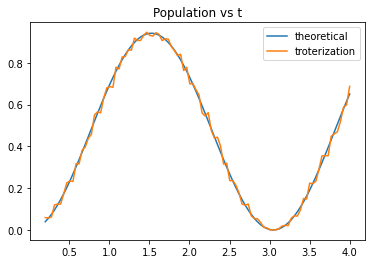

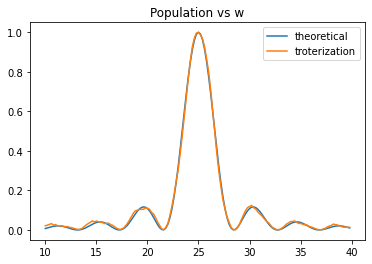

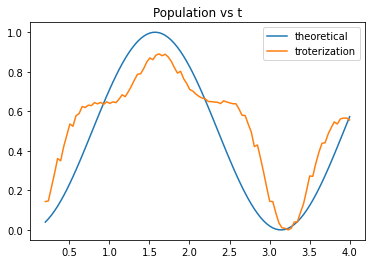

In [32]:
plt.figure()
plt.title('Population vs t')
plt.plot(ts, theo_a, label='theoretical')
plt.plot(ts, pop_a, label='troterization')
plt.legend()
plt.show()

plt.figure()
plt.title('Population vs w')
plt.plot(ws, theo_b, label='theoretical')
plt.plot(ws, pop_b, label='troterization')
plt.legend()
plt.show()

plt.figure()
plt.title('Population vs t')
plt.plot(ts, theo_c, label='theoretical')
plt.plot(ts, pop_c, label='troterization')
plt.legend()
plt.show()

# Exercise 7

In [33]:
pop_noise = []
noise = cirq.ConstantQubitNoiseModel(cirq.GeneralizedAmplitudeDampingChannel(p=0.5,gamma=0.02))

ts_new = np.linspace(0.2,10,100)

for t in ts_new:
    w, wo, w1 = 25.5, 25, 2
    pop_noise.append(Troterization(w,wo,w1,t,'noise',noise))

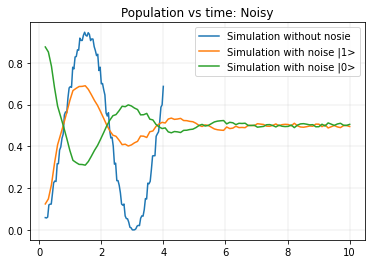

In [34]:
plt.figure()
plt.title('Population vs time: Noisy')
plt.plot(ts, pop_a, label='Simulation without nosie')
plt.plot(ts_new, pop_noise, label='Simulation with noise |1>')
plt.plot(ts_new, 1-np.array(pop_noise), label='Simulation with noise |0>')
plt.legend()
plt.grid(linestyle='-', linewidth=0.2)
plt.show()

In [35]:
ps = [0,0.5,0.9,1]
gammas = [0,0.02,0.1]

populations = np.zeros((len(ps),len(ts),len(gammas)))

w, wo, w1 = 25.5, 25, 2

for i, p in enumerate(ps):
    for j, gamma in enumerate(gammas):
        for k, t in enumerate(ts):
            noise = cirq.ConstantQubitNoiseModel(cirq.GeneralizedAmplitudeDampingChannel(p=p,gamma=gamma))
            populations[i,k,j] = (Troterization(w,wo,w1,t,'noise',noise))

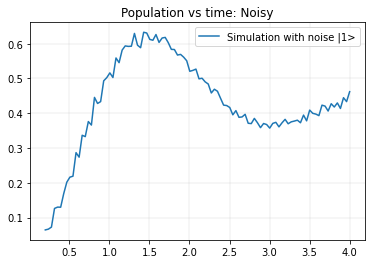

In [36]:
plt.figure()
plt.title('Population vs time: Noisy')
plt.plot(ts, populations[2,:,1], label='Simulation with noise |1>')
plt.legend()
plt.grid(linestyle='-', linewidth=0.2)
plt.show()

***Notes***:

For $p = 1$ the channel reduces to the normal amplitude damping channel \
For $p = 0$ the channel behaves like an amplitude enhancing channel, driving the system to the $|1><1|$ state

# Exercise 8:

In [37]:

def Expectation(prepare='', ops='', reps=int(1e6), debug=False):

    """ 
    prepare: gates to prepare initial state
    ops: operators to change the Z measurement basis into another basis
    examples: 
    - for measurement in X basis: H    
    - for measurement in Y basis: Sdagger, H
    """

    qubits = cirq.LineQubit.range(1)
    q0 = qubits[0]

    simulator = cirq.Simulator(seed=np.random.seed(2))
    measurement_op = cirq.Circuit()

    if prepare:
        measurement_op.append(p(q0) for p in prepare)
    if ops:
        measurement_op.append(p(q0) for p in ops)

    measurement_op.append(cirq.measure(q0))

    if debug:
        print(measurement_op)

    result = simulator.run(measurement_op, repetitions = reps)
    counts = result.histogram(key = '0')

    print(counts)

    N0, N1 = counts[0], counts[1]

    return (N0-N1)/reps


prepare = [cirq.H, cirq.T]

ops_X = [cirq.H]
ops_Y = [cirq.S**-1, cirq.H]

EZ = Expectation(prepare, debug=True)
EX = Expectation(prepare, ops_X, debug=True)
EY = Expectation(prepare, ops_Y, debug=True)

print('Expectation value of Z gate: ', EZ)
print('Expectation value of X gate: ', EX)
print('Expectation value of Y gate: ', EY)


0: ───H───T───M───
Counter({0: 500488, 1: 499512})
0: ───H───T───H───M───
Counter({0: 853353, 1: 146647})
0: ───H───T───S^-1───H───M───
Counter({0: 853353, 1: 146647})
Expectation value of Z gate:  0.000976
Expectation value of X gate:  0.706706
Expectation value of Y gate:  0.706706


# Exercise 9:

Idea: to get the state we can diagonalize the matrix, and obtain the first (and only) eigen state, that would be our initial pure state

In [38]:
# calculating the c_i for the density matrix

rho_tomo = 0.5*np.eye(2, dtype = np.complex128)

Es = [EZ, EX, EY] # list of expectation values

paulis = [cirq.Z, cirq.X, cirq.Y] # list of pauli gates
paulis_matrices = [cirq.unitary(P) for P in paulis] # list of pauli gates as numpy arrays

for i in range(3):
     c = 0.5*Es[i]
     rho_tomo += c*paulis_matrices[i]
    
print(rho_tomo)

w_tomo, v_tomo = LA.eig(rho_tomo)

print(abs(w_tomo[0])**2)
v_tomo[:,0]

[[0.500488+0.j       0.353353-0.353353j]
 [0.353353+0.353353j 0.499512+0.j      ]]
0.9994337665462171


array([0.70745196+0.j       , 0.4997558 +0.4997558j])

In [39]:
#circuit for state tomography
sampler = cirq.DensityMatrixSimulator()

qchain = cirq.LineQubit.range(1)
q0 = qchain[0]

ops = [cirq.H(q0), cirq.T(q0)]

circuit9 = cirq.Circuit(ops)

# print circuit diagram
print(circuit9)

simulator = cirq.Simulator()
result = simulator.simulate(circuit9)
print('Bra-ket notation for the wavefunction:')
print(result.dirac_notation())

result = cirq.experiments.state_tomography(sampler=sampler, qubits=qchain, circuit= circuit9, repetitions=1000000)

rho =  result._density_matrix

print(rho)
print(rho[0,0])


w_function, v_function = LA.eig(rho)

print(abs(w_function[0])**2)
v_function[:,0]

0: ───H───T───
Bra-ket notation for the wavefunction:
0.71|0⟩ + (0.5+0.5j)|1⟩
[[0.499299-4.53246652e-17j 0.353993-3.53156000e-01j]
 [0.353993+3.53156000e-01j 0.500701+1.11022302e-16j]]
(0.4992989999999998-4.532466518368394e-17j)
9.421734375382184e-10


array([ 0.70760226+0.j        , -0.50024045-0.49905765j])

In [40]:
# comparison:
print(LA.norm(rho_tomo - rho))

0.0019298341897689055


# Exercise 10

In [56]:
ts_10 = np.linspace(0.2,2,100)
pop_10 = []
theo_10 = []
for t in ts_10:
    w, wo, w1 = 25.5, 25, 2
    theo_10.append(Population(w,wo,w1,t))
    pop_10.append(Troterization(w,wo,w1,t,'tomography'))

/Users/emiliano_gr/opt/anaconda3/envs/google-quantum/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


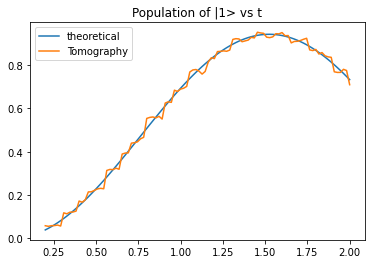

In [82]:
plt.figure()
plt.title('Population of |1> vs t')
plt.plot(ts_10, np.array(theo_10), label='theoretical')
plt.plot(ts_10, pop_10, label='Tomography')
plt.legend()
plt.show()

# Exercise 11:

In [43]:
"""Define a custom gate with a parameter."""
class RXZ(cirq.Gate):
    def __init__(self, b):
        super(RXZ, self)
        self.b = b

    def _num_qubits_(self):
        return 2

    def _unitary_(self):
        return np.array([
            [np.cos(self.b), 0.0, 1j*np.sin(self.b),  0.0],
            [0.0,  np.cos(self.b), 0.0,  -1j*np.sin(self.b)],
            [1j*np.sin(self.b),  0.0, np.cos(self.b),  0.0],
            [0.0,  -1j*np.sin(self.b), 0.0, np.cos(self.b)]
        ])

    def _circuit_diagram_info_(self, args):
        return f"RXZ({self.b})",  f"RXZ({self.b})"
    
class RZX(cirq.Gate):
    def __init__(self, b):
        super(RZX, self)
        self.b = b

    def _num_qubits_(self):
        return 2

    def _unitary_(self):
        return np.array([
            [np.cos(self.b), 1j*np.sin(self.b), 0.0,  0.0],
            [1j*np.sin(self.b), np.cos(self.b), 0.0,  0.0],
            [0.0, 0.0, np.cos(self.b), -1j*np.sin(self.b)],
            [0.0, 0.0, -1j*np.sin(self.b), np.cos(self.b)]
        ])

    def _circuit_diagram_info_(self, args):
        return f"RZX({self.b})",  f"RZX({self.b})"
    
def expXZ(b):
    " exp(ib(XZ)) acting on two qubits"
    q_chain = cirq.LineQubit.range(2)
    rotation = cirq.Circuit()
    rotation.append(RXZ(b=b).on(*q_chain))
    return rotation

def expZX(b):
    " exp(ib(ZX)) acting on two qubits"
    q_chain = cirq.LineQubit.range(2)
    rotation = cirq.Circuit()
    rotation.append(RZX(b=b).on(*q_chain))
    return rotation


def ansatz(a,b):
    q_chain = cirq.LineQubit.range(2)
    circ = cirq.Circuit()

    rz = cirq.rz(-2*a)

    circ.append(expZX(b))
    circ.append(expXZ(b))

    circ.append(rz(q_chain[1]))
    circ.append(rz(q_chain[0]))

    return circ

# testing our implementation of the Ansatz circuit
ansatz_state = ansatz(np.pi/2,np.pi/2)
print(ansatz_state)

result = simulator.simulate(ansatz_state)
print('Bra-ket notation for the wavefunction:')
print(result.dirac_notation()) #this is correct

0: ───RZX(1.5707963267948966)───RXZ(1.5707963267948966)───Rz(-π)───
      │                         │
1: ───RZX(1.5707963267948966)───RXZ(1.5707963267948966)───Rz(-π)───
Bra-ket notation for the wavefunction:
-1|11⟩


In [44]:
# Exercise 12

alist = np.linspace(0,np.pi,20)
blist = np.linspace(0,np.pi,20)

energies = np.empty(shape=(len(alist),len(blist)))

q_chain = cirq.LineQubit.range(2)
q0 = q_chain[0]
q1 = q_chain[1]


for i, a in enumerate(alist):
    for j, b in enumerate(blist):
        energies[i,j] = simulator.simulate_expectation_values(ansatz(a,b), observables=-cirq.Z(q0)*cirq.X(q1)-cirq.X(q0)*cirq.Z(q1) )[0].real

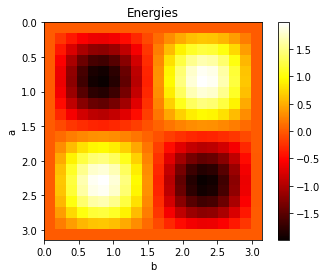

In [45]:
pos = plt.imshow(energies, cmap='hot', interpolation='nearest', extent=[0,alist[-1],blist[-1],0])

plt.title('Energies')
plt.ylabel('a')
plt.xlabel('b')
plt.colorbar(pos)

plt.show()

In [46]:
print("The smallest energy is: ", np.amin(energies)) #should be -2 in theory
arg = np.argmin(energies)
print(arg)
bmin= arg%20
amin= (arg)//20
print("Indices for the arrays are: (i: {} and j: {}) ".format(amin,bmin) )
print("Values for the indices are: (a: {} and b: {}) ".format(alist[amin],blist[bmin]))

The smallest energy is:  -1.986361026763916
105
Indices for the arrays are: (i: 5 and j: 5) 
Values for the indices are: (a: 0.8267349088394192 and b: 0.8267349088394192) 


In [47]:
print(np.where(energies == np.amin(energies))) #printing the pair of indices for which the min is achieved
# here this is (5,5) and (14,14)

(array([ 5, 14]), array([ 5, 14]))


In [48]:
test =simulator.simulate_expectation_values(ansatz(alist[14],alist[14]), observables=-cirq.Z(q0)*cirq.X(q1)-cirq.X(q0)*cirq.Z(q1) )[0]
print('Energy of ground state:', round(test.real,3))

Energy of ground state: -1.986


In [65]:
def entanglement_entropy(circ, simulator=cirq.Simulator()):

    result = simulator.simulate(circ)
    state = result.final_state_vector # np.array(shape=2**L)

    state = state/np.linalg.norm(state) 

    C = np.reshape(state, newshape=(2,2))

    u, s, vh = LA.svd(C) #singual value decomposition U, Vh = isometries U@S@Vh = C

    ent = 0
    for sigma in s:
        if sigma != 0:
            ent -= sigma**2 * log(sigma**2,2)

    return ent

In [74]:
#13

test_ent = 0

for i in range(20):

    print(i)
    gs = ansatz(alist[i],blist[bmin])
    #print(gs)

    result = simulator.simulate(gs)
    state = result.final_state_vector

    # print('=====================================')
    # print('Bra-ket notation for the wavefunction:')
    # print(result.dirac_notation())
    # print('=====================================')

    #correct up to a global phase of e^(-ipi/2)
    gs_state = np.array([1,1,1,-1])*0.5
    # print(gs_state)

    # print('Including the global phase and taking only the real part: ')
    # print((np.exp(-1j*np.pi/2)*state).real)
    # print(cirq.equal_up_to_global_phase(gs_state, state, atol=1))
    
    print(entanglement_entropy(gs)) #should be equal to 1 in theory
    print(entanglement_entropy(gs)-  test_ent)
    test_ent = entanglement_entropy(gs)





0
0.9901729620916271
0.9901729620916271
1
0.9901729411867946
-2.0904832531698503e-08
2
0.9901728875842513
-5.36025432928966e-08
3
0.9901728875842513
0.0
4
0.9901729620916271
7.45073758245951e-08
5
0.9901729411867946
-2.0904832531698503e-08
6
0.9901729829964372
4.180964263689191e-08
7
0.9901729620916271
-2.0904810105193405e-08
8
0.9901729084890839
-5.3602543181874296e-08
9
0.9901729084890839
0.0
10
0.9901729084890839
0.0
11
0.9901729084890839
0.0
12
0.9901729620916271
5.3602543181874296e-08
13
0.9901729829964372
2.0904810105193405e-08
14
0.9901729411867946
-4.180964263689191e-08
15
0.9901729620916271
2.0904832531698503e-08
16
0.9901728875842513
-7.45073758245951e-08
17
0.9901728875842513
0.0
18
0.9901729411867946
5.36025432928966e-08
19
0.9901729620916271
2.0904832531698503e-08


In [63]:
# Exercise 15:

entanglement = np.empty(shape=(len(alist),len(blist)))

simulator = cirq.Simulator()

for i, a in enumerate(alist):
    for j, b in enumerate(blist):
        ansatz_state = ansatz(a,b)
        entanglement[i,j] = entanglement_entropy(ansatz_state, simulator)

        

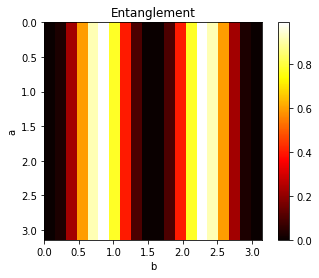

In [64]:
pos2 = plt.imshow(entanglement, cmap='hot', interpolation='nearest', extent=[0,alist[-1],blist[-1],0])

plt.title('Entanglement')
plt.ylabel('a')
plt.xlabel('b')
plt.colorbar(pos2)

plt.show()

In [76]:
print("The highest Entropy is: ", np.amax(entanglement))
arg = np.argmax(entanglement)
print('at',arg)
b= arg%20
a= (arg-b)//20
print("Indices in the arrays are: (i: {} and j: {}) ".format(a,b) )
print("Values for the indices are: (a: {} and b: {}) ".format(alist[a],blist[b]) )

The highest Entropy is:  0.9901729829964372
at 125
Indices in the arrays are: (i: 6 and j: 5) 
Values for the indices are: (a: 0.992081890607303 and b: 0.8267349088394192) 


In [77]:
print(np.where(entanglement == np.amax(entanglement))) #printing the pair of indices for which the min is achieved

(array([ 6,  6, 13, 13]), array([ 5, 14,  5, 14]))


In [81]:
alist = np.linspace(0,np.pi,20)
blist = np.linspace(0,np.pi,20)


for i in range(20):
    test = ansatz(alist[i],blist[5])
    print(entanglement_entropy(test, simulator))

0.9901729620916271
0.9901729411867946
0.9901728875842513
0.9901728875842513
0.9901729620916271
0.9901729411867946
0.9901729829964372
0.9901729620916271
0.9901729084890839
0.9901729084890839
0.9901729084890839
0.9901729084890839
0.9901729620916271
0.9901729829964372
0.9901729411867946
0.9901729620916271
0.9901728875842513
0.9901728875842513
0.9901729411867946
0.9901729620916271


the two ground states encountered coincid with points where entanglement is highest

# Not used:

In [ ]:
def Troterization_noise(w,wo,w1,t):
    
    noise = cirq.ConstantQubitNoiseModel(cirq.GeneralizedAmplitudeDampingChannel(p=0.9,gamma=0.02))
    
    troter = U(w,wo,w1,t)
    
    reps = 10000
    
    troter.append(cirq.measure(q_chain[0]))
    result = cirq.sample(program=troter, noise=noise, repetitions=reps) # type(result) = <class 'cirq.study.result.ResultDict'>
    
    # other keys don't seem to work
    # type(histogram) = <class 'collections.Counter'>
    histogram = result.histogram(key = '0') 
    
    # _ = cirq.plot_state_histogram(histogram, plt.subplot())
    # plt.show()

    # population for state |1> := prob(measurement=1)
    population = histogram[1]/reps
    

In [ ]:
# Test for entanglement entropy in a bell state

q0,q1 = cirq.LineQubit.range(2)

circ = cirq.Circuit(cirq.H(q0), cirq.CNOT(q0,q1))

print(circ)

result = simulator.simulate(circ)
state = result.final_state_vector

C = np.reshape(state, newshape=(2,2))

print(C)

u, s, vh = LA.svd(C)

ent = 0

for sigma in s:
    if sigma != 0:
        ent -= sigma**2 * log(sigma**2,2)

ent #should be equal to 1 by definition
#entanglement= cirq.von_neumann_entropy(density)
#print(entanglement)

0: ───H───@───
          │
1: ───────X───
[[0.70710677+0.j 0.        +0.j]
 [0.        +0.j 0.70710677+0.j]]


1.0000000151528048